In [1]:
import itertools
import random
import re

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, models
import transformers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
VOCABULARY = [str(d) for d in range(10)] + ['+', '=', 'Q', 'E', 'F', '!']
VOCABULARY

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '+',
 '=',
 'Q',
 'E',
 'F',
 '!']

In [3]:
def data(n_samples, max_n_digits, seed, min_n_digits=1):
    random.seed(seed)
    already_generated = set()
    
    while True:
        if len(already_generated) >= n_samples:
            break
        
        n_digits = random.randint(min_n_digits, max_n_digits)
        
        a = random.randint(0, 10 ** n_digits - 1)
        b = random.randint(0, 10 ** n_digits - 1)
        
        if (a, b) in already_generated:
            continue
        
        already_generated.add((a, b))
        
        problem = f'{a:0{n_digits}d}+{b:0{n_digits}d}'

        carry = 0
        
        for significance in range(n_digits):
            a_digit = (a // 10 ** significance) % 10
            b_digit = (b // 10 ** significance) % 10
            result = a_digit + b_digit + carry
            result_digit = result % 10
            result_carry = result // 10
            problem += f'Q{carry}+{a_digit}+{b_digit}E{result_carry}{result_digit}'
            carry = result_carry
        
        problem += f'F{a+b}!'
        
        yield problem

next(data(100, 3, 0))

'97+53Q0+7+3E10Q1+9+5E15F150!'

In [4]:
def tokenize(s):
    s = list(s)
    return np.array([VOCABULARY.index(c) for c in s], dtype=np.int32)

def detokenize(arr):
    return ''.join([VOCABULARY[x] for x in arr])

In [5]:
def system_1(s):
    return f'{eval(s):02d}'

system_1('7+1+0')

'08'

In [6]:
def data_generator(dataset):
    for example in dataset:
        idxs = [(m.start(0), m.end(0))
                for m in re.finditer('Q.\+.\+.E|F.*!', example[1:])]
        
        tokens = tokenize(example)
        inputs = tokens[:-1]
        targets = tokens[1:]
        
        mask = np.array([0] * len(targets))
        for s, e in idxs:
            mask[s:e] = 1
        
        yield inputs, targets, mask

In [7]:
def decode(model, a, b):
    n_digits = max(len(str(a)), len(str(b)))
    ex = f"{a:0{n_digits}d}+{b:0{n_digits}d}"
    tokenized = tokenize(ex).astype(np.int32)
    
    while True:
        while not tokenized[-1] in (VOCABULARY.index('E'), VOCABULARY.index('!')):
            pred = model(tokenized[np.newaxis, ...])
            pred = pred.numpy()
            next_token = np.argmax(pred, axis=-1)[0, -1].astype(np.int32)
            tokenized = np.append(tokenized, next_token)

        if tokenized[-1] == VOCABULARY.index('E'):
            # Call system 1
            query = detokenize(tokenized)[-6:-1]
            ans = system_1(query)
            tokenized_ans = tokenize(ans)
            tokenized = np.append(tokenized, tokenized_ans)

        elif tokenized[-1] == VOCABULARY.index('!'):
            break

    return detokenize(tokenized)

In [15]:
def evaluate(model, test_dataset):
    n_correct = 0
    for example in test_dataset:
        i = example.index('Q')
        ab = example[:i]
        i = ab.index('+')
        a = int(ab[:i])
        b = int(ab[i:])

        try:
            ans = decode(model, a, b)
            i = ans.index('F')
            ans = ans[i+1:-1]
            ans = int(ans)

            if ans == a + b:
                n_correct += 1
        except ValueError as err:
            print("ValueError in eval:", err)
        except SyntaxError as err:
            print("SyntaxError in eval:", err)

    return n_correct / len(test_dataset)

In [9]:
def build_model(vocab_size):
    inputs = layers.Input((None,), dtype=tf.int32)
    x = inputs
    x = layers.Embedding(vocab_size, 64)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dense(vocab_size, activation='softmax')(x)
    model = models.Model(inputs, x)
    
    return model

In [10]:
def build_attention_model(vocab_size):
    inputs = layers.Input((None,), dtype=tf.int32)
    x = inputs
    x = layers.Embedding(vocab_size, 64)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    
    # Attention mechanism.
    seq_len = tf.shape(x)[1]
    keys = layers.Dense(128)(x)
    look_ahead_mask = (1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)) * -1e9
    look_ahead_mask = look_ahead_mask[tf.newaxis, ...]
    attention_scores = x @ tf.transpose(keys, [0, 2, 1])
    attention_scores = attention_scores + look_ahead_mask
    attention_weights = tf.nn.softmax(attention_scores, name="attention_weights")
    x_att = attention_weights @ x
    x = layers.Concatenate()([x, x_att])
    
    x = layers.Dense(vocab_size, activation='softmax')(x)
    model = models.Model(inputs, x)
    
    return model

In [11]:
def build_copy_model(vocab_size):
    inputs = layers.Input((None,), dtype=tf.int32)
    x = inputs
    x = layers.Embedding(vocab_size, 64)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    
    batch_size = tf.shape(x)[0]
    seq_len = tf.shape(x)[1]
    keys = layers.Dense(128)(x)
    look_ahead_mask = (1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)) * -1e9
    look_ahead_mask = look_ahead_mask[tf.newaxis, ...]
    attention_scores = x @ tf.transpose(keys, [0, 2, 1])
    attention_scores = attention_scores + look_ahead_mask
    attention_weights = tf.nn.softmax(attention_scores, name="attention_weights")
    x_att = attention_weights @ x
    x = layers.Concatenate()([x, x_att])
    
    # Generative distribution.
    gen_dist = layers.Dense(vocab_size, activation='softmax')(x)
    
    # Copy mechanism based distribution.
    indices = tf.range(batch_size, dtype=tf.int32)[:, tf.newaxis]  # (bs, 1)
    indices = tf.tile(indices, [1, seq_len])  # (bs, seq_len)
    indices = tf.stack((indices, inputs), axis=2)
    #indices = tf.transpose(indices, perm=[1, 2, 0])  # (bs, seq_len, 2)
    updates = tf.transpose(attention_weights, perm=[0, 2, 1])
    output_shape = [batch_size, vocab_size, seq_len]
    copy_dist = tf.scatter_nd(indices, updates, output_shape)
    copy_dist = tf.transpose(copy_dist, [0, 2, 1])
    
    # Combine distributions.
    p_gen_pre_logit = layers.Concatenate()([x_att, keys])
    p_gen = layers.Dense(1, activation="sigmoid")(p_gen_pre_logit)
    dist = p_gen * gen_dist + (1 - p_gen) * copy_dist 
    
    model = models.Model(inputs, dist)
    
    return model

In [25]:
def get_model(model_type):
    vocab_size = len(VOCABULARY)
    if model_type == "baseline":
        model = build_model(vocab_size)
    elif model_type == "attention":
        model = build_attention_model(vocab_size)
    elif model_type == "copy":
        model = build_copy_model(vocab_size)
    else:
        raise Exception("Invalid model.")
    model.build(input_shape=(None, None))
    return model

In [26]:
def run_experiment(train_dataset, test_dataset, model):
    tf.keras.backend.clear_session()
    
    batch_size = 64

    train_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(train_dataset),
        output_types=(tf.int32, tf.int32, tf.int32),
        output_shapes=(
            tf.TensorShape((None,)), 
            tf.TensorShape((None,)), 
            tf.TensorShape((None,))
        ))
    train_ds = train_ds.shuffle(10000)
    train_ds = train_ds.padded_batch(batch_size, padded_shapes=([None], [None], [None]))

    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    
    optimizer = optimizers.Adam(1e-3)

    @tf.function
    def train_step(inputs, targets, mask):
        with tf.GradientTape() as tape:
            outputs = model(inputs)
            loss = tf.losses.sparse_categorical_crossentropy(targets, outputs)
            loss = tf.boolean_mask(loss, tf.cast(mask, tf.bool))
            loss = tf.reduce_mean(loss)

            masked_outputs = tf.boolean_mask(outputs, tf.cast(mask, tf.bool))
            accuracy(targets, outputs, sample_weight=mask)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return loss

    accuracy_history = []
    stop_criteria_last_n = 5
    
    for i, (inputs, targets, mask) in train_ds.repeat(None).take(4000).enumerate():
        accuracy.reset_states()
        loss = train_step(inputs, targets, mask)
        if i % 100 == 0 and i > 0:
            print(
                'Step', i.numpy(),
                'Loss', loss.numpy(),
                'Acc', accuracy.result().numpy())
            accuracy_history.append(accuracy.result().numpy())
            if len(accuracy_history) > stop_criteria_last_n:
                accuracy_history = accuracy_history[1:]
            if sum(accuracy_history) >= 1.0 * stop_criteria_last_n - 0.001:
                break
    
    accuracy = evaluate(model, test_dataset)
    
    return accuracy, model

## Baseline

In [27]:
dataset = data(
    n_samples=5000,
    max_n_digits=2,
    seed=0)
dataset = list(dataset)

test_dataset = dataset[-300:]

n_train_sizes = [100, 500, 1000, 2000]
accuracies = []

for n_train in n_train_sizes:
    train_dataset = dataset[:n_train]
    model = get_model(model_type="baseline")
    accuracy, _ = run_experiment(train_dataset, test_dataset, model)
    accuracies.append(accuracy)
    
plt.plot(n_train_sizes, accuracies)
plt.show()

Step 100 Loss 1.3457814 Acc 0.64203954
Step 200 Loss 0.70420176 Acc 0.75947994
Step 300 Loss 0.58641523 Acc 0.8057022
Step 400 Loss 0.43101612 Acc 0.86687964
Step 500 Loss 0.30489555 Acc 0.9095634
Step 600 Loss 0.16828047 Acc 0.96447796
Step 700 Loss 0.082351364 Acc 0.9918284
Step 800 Loss 0.043892827 Acc 1.0
Step 900 Loss 0.025749868 Acc 1.0
Step 1000 Loss 0.015854716 Acc 1.0
Step 1100 Loss 0.011685202 Acc 1.0
Step 1200 Loss 0.008689083 Acc 1.0
ValueError in eval: invalid literal for int() with base 10: '1F99'
Step 100 Loss 1.6255708 Acc 0.5972222
Step 200 Loss 0.8392676 Acc 0.7048138
Step 300 Loss 0.74444896 Acc 0.7283721
Step 400 Loss 0.6709831 Acc 0.7647059
Step 500 Loss 0.604929 Acc 0.78977275
Step 600 Loss 0.543627 Acc 0.8221601
Step 700 Loss 0.45679596 Acc 0.84768814
Step 800 Loss 0.39452314 Acc 0.8764548
Step 900 Loss 0.2841471 Acc 0.9134701
Step 1000 Loss 0.1996432 Acc 0.9505494
Step 1100 Loss 0.14698721 Acc 0.97077626
Step 1200 Loss 0.09047778 Acc 0.98541474
Step 1300 Loss 0.

KeyboardInterrupt: 

In [ ]:
accuracies

## Baseline + self attention

In [ ]:
dataset = data(
    n_samples=5000,
    max_n_digits=2,
    seed=0)
dataset = list(dataset)

test_dataset = dataset[-300:]

n_train_sizes = [100, 500, 1000, 2000]
accuracies = []
for n_train in n_train_sizes:
    train_dataset = dataset[:n_train]
    model = get_model(model_type="attention")
    accuracy, _ = run_experiment(train_dataset, test_dataset, model)
    accuracies.append(accuracy)
    
plt.plot(n_train_sizes, accuracies)
plt.show()

In [ ]:
accuracies

## Baseline + self attention + copy mechanism

In [ ]:
dataset = data(
    n_samples=5000,
    max_n_digits=2,
    seed=0)
dataset = list(dataset)

test_dataset = dataset[-300:]

n_train_sizes = [20, 50, 75, 100]
accuracies = []
for n_train in n_train_sizes:
    train_dataset = dataset[:n_train]
    model = get_model(model_type="copy")
    accuracy, _ = run_experiment(train_dataset, test_dataset, model)
    accuracies.append(accuracy)
    
plt.plot(n_train_sizes, accuracies)
plt.show()

In [ ]:
accuracies

## Increasing num digits in training data

In [ ]:
train_dataset = data(
    n_samples=20000,
    max_n_digits=10,
    seed=0)
train_dataset = list(train_dataset)

test_dataset = data(
    n_samples=100,
    max_n_digits=11,
    min_n_digits=11,
    seed=0)
test_dataset = list(test_dataset)

accuracy, model = run_experiment(train_dataset, test_dataset, model_type="copy")
print(accuracy)

In [ ]:
decode(model, 11111, 22222)

## Model inspection

In [ ]:
ex = "123+567Q0+3+7E1"
tokenized = tokenize(ex)

model2 = models.Model(
    inputs=model.inputs,
    outputs=[model.outputs, model.get_layer('tf_op_layer_add_1').output])

pred, att_weights = model2(tokenized[np.newaxis, ...])
print("Softmax output:")
print(pred[0][0, -1, :])
print('Argmax token:', VOCABULARY[np.argmax(pred[0][0, -1, :])])

print("Attention weights:")
plt.plot(att_weights[0, -1, :])

[0.89, 0.9966666666666667]

## Increasing num digits in training data

In [ ]:
train_dataset = data(
    n_samples=20000,
    max_n_digits=10,
    seed=0)
train_dataset = list(train_dataset)

test_dataset = data(
    n_samples=100,
    max_n_digits=11,
    min_n_digits=11,
    seed=0)
test_dataset = list(test_dataset)

accuracy, model = run_experiment(train_dataset, test_dataset, model_type="copy")
print(accuracy)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     1024        input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 128)    98816       embedding[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Shape_1 (TensorFlow [(3,)]               0           lstm[0][0]                       
______________________________________________________________________________________________

In [ ]:
decode(model, 11111, 22222)

## Model inspection

Softmax output:
tf.Tensor(
[5.4974299e-07 4.5491379e-06 2.3568574e-09 5.8792615e-10 3.0597482e-09
 2.8557656e-09 1.7530151e-09 2.7995368e-09 2.7640148e-09 1.1759320e-08
 5.5896015e-07 2.2194342e-11 9.8302680e-01 1.6953945e-02 1.3359379e-05
 1.6310629e-07], shape=(16,), dtype=float32)
Argmax token: Q
Attention weights:


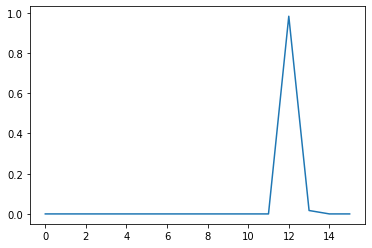

In [28]:
ex = "123+567Q0+3+7E1"
tokenized = tokenize(ex)

model2 = models.Model(
    inputs=model.inputs,
    outputs=[model.outputs, model.get_layer('tf_op_layer_add_1').output])

pred, att_weights = model2(tokenized[np.newaxis, ...])
print("Softmax output:")
print(pred[0][0, -1, :])
print('Argmax token:', VOCABULARY[np.argmax(pred[0][0, -1, :])])

print("Attention weights:")
plt.plot(att_weights[0, -1, :])

## Curriculum learning

In [30]:
model = get_model(model_type="copy")
for max_n_digits in [2,3,4,6,8]:
    train_dataset = data(
        n_samples=10000,
        max_n_digits=max_n_digits,
        seed=0)
    train_dataset = list(train_dataset)

    test_dataset = data(
        n_samples=100,
        max_n_digits=max_n_digits+1,
        min_n_digits=max_n_digits+1,
        seed=0)
    test_dataset = list(test_dataset)

    accuracy, _ = run_experiment(train_dataset, test_dataset, model)
    print("Accuracy with max {} digits, evaluating on {} digits: {}".format(max_n_digits, max_n_digits + 1, 
                                                                            accuracy))

Step 100 Loss 1.0844855 Acc 0.7380952
Step 200 Loss 0.0671819 Acc 0.99745333
Step 300 Loss 0.020122066 Acc 0.99831367
Step 400 Loss 0.046948962 Acc 0.9922747
Step 500 Loss 0.008210928 Acc 0.99914676
Step 600 Loss 0.0049689612 Acc 1.0
Step 700 Loss 0.0041937996 Acc 1.0
Step 800 Loss 0.0021872132 Acc 1.0
Step 900 Loss 0.018684015 Acc 0.99743587
Step 1000 Loss 0.0014263749 Acc 1.0
Step 1100 Loss 0.0017907986 Acc 1.0
Step 1200 Loss 0.00137163 Acc 1.0
Step 1300 Loss 0.0043881163 Acc 0.99914384
Step 1400 Loss 0.010941404 Acc 0.9965928
Step 1500 Loss 0.0013565168 Acc 1.0
Step 1600 Loss 0.0005495819 Acc 1.0
Step 1700 Loss 0.0004790116 Acc 1.0
Step 1800 Loss 0.00045244486 Acc 1.0
Step 1900 Loss 0.00036784488 Acc 1.0
ValueError in eval: Unknown format code 'd' for object of type 'float'
Accuracy with max 2 digits, evaluating on 3 digits: 0.01
Step 100 Loss 0.02150888 Acc 0.997905
Step 200 Loss 0.00885637 Acc 1.0
Step 300 Loss 0.003935226 Acc 1.0
Step 400 Loss 0.002551656 Acc 1.0
Step 500 Loss 0.

NameError: name 'Q1' is not defined